In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 📂 Load dataset
df = pd.read_csv("../data/mobile_funnel_data.csv", parse_dates=['date'])

# ✅ ETL: Derived columns
COST_PER_IMPRESSION = 0.01  # Assume fixed ad cost

df['CTR'] = df['clicks'] / df['impressions']
df['Conversion'] = df['purchases'] / df['installs'].replace(0, 1)
df['CPI'] = (df['impressions'] * COST_PER_IMPRESSION) / df['installs'].replace(0, 1)
df['LTV'] = df['revenue'] / df['installs'].replace(0, 1)
df['ROI'] = df['LTV'] / df['CPI'].replace(0, 1)

df.head()

,user_id,campaign,date,impressions,clicks,installs,purchases,revenue,retained_day_7,CTR,Conversion,CPI,LTV,ROI
0,0,A,2024-01-01,56,16,6,1,8.12,0,0.285714,0.166667,0.093333,1.353333,14.500000
1,1,A,2024-01-01,79,20,6,1,5.41,1,0.253165,0.166667,0.131667,0.901667,6.848101
2,2,B,2024-01-01,34,6,1,0,0.00,0,0.176471,0.000000,0.340000,0.000000,0.000000
3,3,B,2024-01-01,93,21,7,0,0.00,0,0.225806,0.000000,0.132857,0.000000,0.000000
4,4,B,2024-01-01,66,19,4,0,0.00,0,0.287879,0.000000,0.165000,0.000000,0.000000


In [3]:
campaign_kpis = df.groupby('campaign').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'installs': 'sum',
    'purchases': 'sum',
    'revenue': 'sum',
    'CTR': 'mean',
    'Conversion': 'mean',
    'CPI': 'mean',
    'LTV': 'mean',
    'ROI': 'mean',
    'retained_day_7': 'mean'
}).round(2)

display(campaign_kpis)

,impressions,clicks,installs,purchases,revenue,CTR,Conversion,CPI,LTV,ROI,retained_day_7
campaign,,,,,,,,,,,
A,3873010,775551,232326,23101,345949.49,0.20,0.09,0.20,1.31,8.95,0.2
B,3920869,982440,295787,29519,442652.05,0.25,0.09,0.16,1.36,11.35,0.3


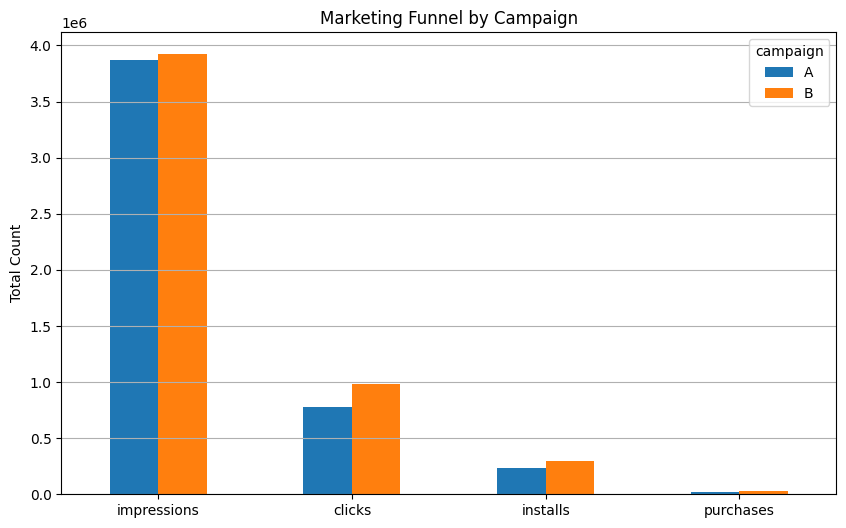

In [4]:
funnel = df.groupby('campaign')[['impressions','clicks','installs','purchases']].sum().T

funnel.plot(kind='bar', figsize=(10, 6))
plt.title("Marketing Funnel by Campaign")
plt.ylabel("Total Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

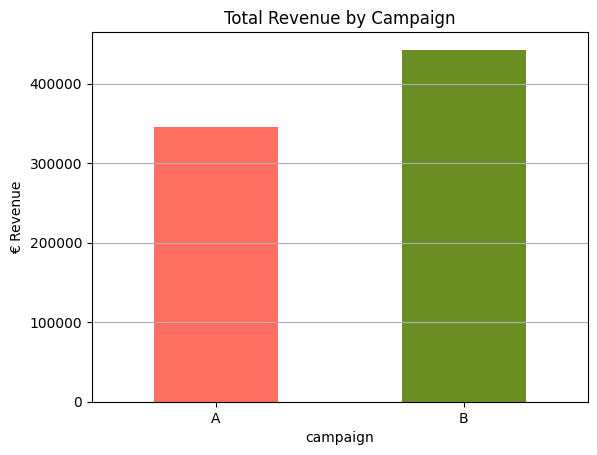

In [5]:
revenue_by_campaign = df.groupby('campaign')['revenue'].sum()

revenue_by_campaign.plot(kind='bar', color=['#FF6F61', '#6B8E23'])
plt.title("Total Revenue by Campaign")
plt.ylabel("€ Revenue")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [6]:
# Test CTR
t_stat_ctr, p_ctr = ttest_ind(
    df[df['campaign'] == 'A']['CTR'].dropna(),
    df[df['campaign'] == 'B']['CTR'].dropna()
)

# Test Conversion
t_stat_conv, p_conv = ttest_ind(
    df[df['campaign'] == 'A']['Conversion'].dropna(),
    df[df['campaign'] == 'B']['Conversion'].dropna()
)

# Test ROI
t_stat_roi, p_roi = ttest_ind(
    df[df['campaign'] == 'A']['ROI'].dropna(),
    df[df['campaign'] == 'B']['ROI'].dropna()
)

# Test Retention
t_stat_ret, p_ret = ttest_ind(
    df[df['campaign'] == 'A']['retained_day_7'].dropna(),
    df[df['campaign'] == 'B']['retained_day_7'].dropna()
)

print(f"CTR:     t = {t_stat_ctr:.3f}, p = {p_ctr:.3f}")
print(f"Conversion: t = {t_stat_conv:.3f}, p = {p_conv:.3f}")
print(f"ROI:     t = {t_stat_roi:.3f}, p = {p_roi:.3f}")
print(f"Retention:  t = {t_stat_ret:.3f}, p = {p_ret:.3f}")

CTR:     t = -129.420, p = 0.000
Conversion: t = -3.058, p = 0.002
ROI:     t = -19.373, p = 0.000
Retention:  t = -44.886, p = 0.000


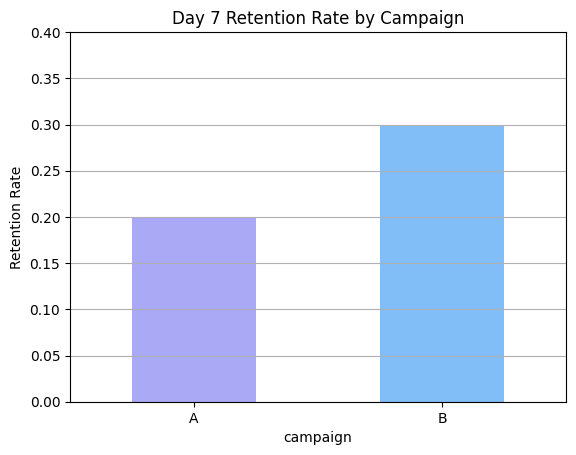

In [7]:
retention = df.groupby('campaign')['retained_day_7'].mean()

retention.plot(kind='bar', color=['#A9A9F5', '#81BEF7'])
plt.title("Day 7 Retention Rate by Campaign")
plt.ylabel("Retention Rate")
plt.xticks(rotation=0)
plt.ylim(0, 0.4)
plt.grid(axis='y')
plt.show()

In [8]:
# --- DAU: unique users per day ---
dau_daily = df.groupby('date')['user_id'].nunique().rename('DAU').reset_index()
dau_daily.head()

,date,DAU
0,2024-01-01,5000
1,2024-01-02,5000
2,2024-01-03,5000
3,2024-01-04,5000
4,2024-01-05,5000


In [9]:
# --- MAU: unique users per calendar month ---
df['month'] = df['date'].values.astype('datetime64[M]')  # month start
mau_monthly = df.groupby('month')['user_id'].nunique().rename('MAU').reset_index()
mau_monthly.head()

,month,MAU
0,2024-01-01,5000


In [10]:
# --- Monthly stickiness: average daily DAU in month / MAU of that month ---
# 1) daily DAU with month column
dau_daily['month'] = dau_daily['date'].values.astype('datetime64[M]')
# 2) average daily DAU per month
avg_dau_by_month = dau_daily.groupby('month')['DAU'].mean().reset_index().rename(columns={'DAU':'avg_DAU'})
# 3) join with MAU and compute stickiness
stickiness = avg_dau_by_month.merge(mau_monthly, on='month', how='inner')
stickiness['DAU_MAU_ratio'] = stickiness['avg_DAU'] / stickiness['MAU']
stickiness.head()

,month,avg_DAU,MAU,DAU_MAU_ratio
0,2024-01-01,5000.0,5000,1.0


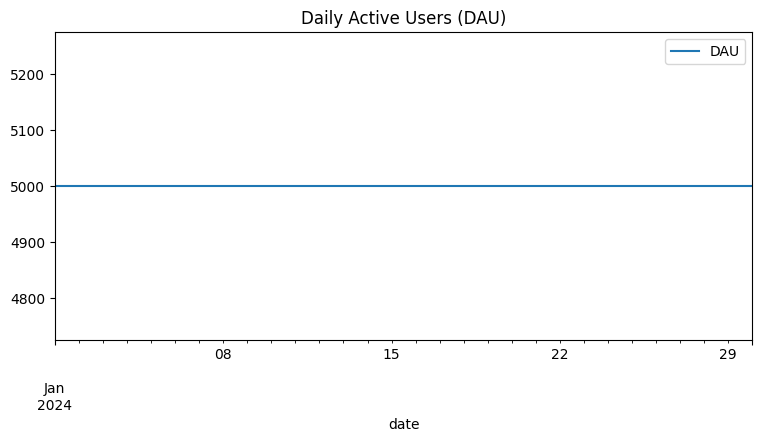

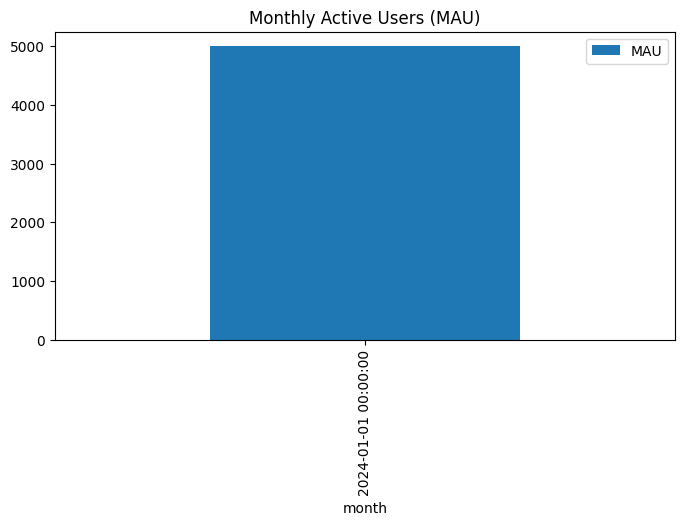

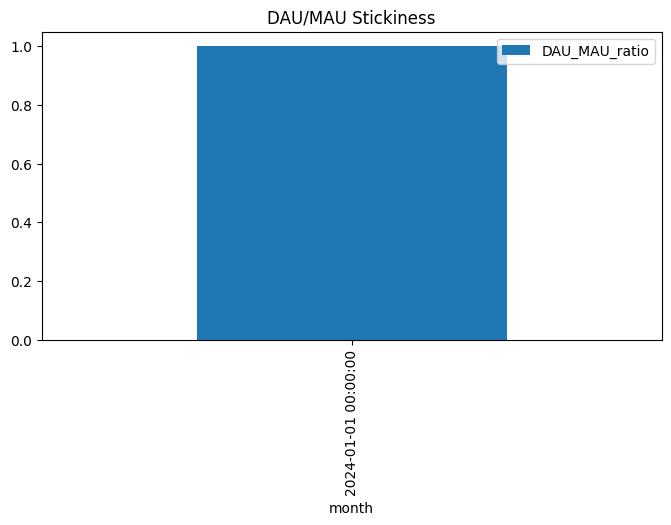

In [11]:
import matplotlib.pyplot as plt

# DAU
dau_daily.plot(x='date', y='DAU', figsize=(9,4), title='Daily Active Users (DAU)')
plt.show()

# MAU
mau_monthly.plot(x='month', y='MAU', kind='bar', figsize=(8,4), title='Monthly Active Users (MAU)')
plt.show()

# Stickiness
stickiness.plot(x='month', y='DAU_MAU_ratio', kind='bar', figsize=(8,4), title='DAU/MAU Stickiness')
plt.show()